In [1]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import networkx as nx
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from networkx.algorithms.community import girvan_newman

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset("RealTimeData/bbc_news_alltime", "2017-01")
texts = [item["content"] for item in dataset["train"] if item["content"]]

In [3]:
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(texts[:200], show_progress_bar=True)


Batches: 100%|██████████| 7/7 [00:18<00:00,  2.62s/it]


In [4]:
similarity_matrix = cosine_similarity(embeddings)
threshold = 0.5
G = nx.Graph()

for i in range(len(embeddings)):
    for j in range(i+1, len(embeddings)):
        if similarity_matrix[i, j] > threshold:
            G.add_edge(i, j, weight=similarity_matrix[i, j])


In [5]:
partition_louvain = community_louvain.best_partition(G, weight="weight")

clusters_louvain = {}
for node, comm in partition_louvain.items():
    clusters_louvain.setdefault(comm, []).append(texts[node])



In [6]:
gn_generator = girvan_newman(G)
first_level_communities = next(gn_generator)   # first split
partition_gn = {}
for comm_id, community_nodes in enumerate(first_level_communities):
    for node in community_nodes:
        partition_gn[node] = comm_id

clusters_gn = {}
for node, comm in partition_gn.items():
    clusters_gn.setdefault(comm, []).append(texts[node])


In [7]:
def extract_keywords(clusters):
    community_keywords = {}
    vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
    for comm, docs in clusters.items():
        X = vectorizer.fit_transform(docs)
        scores = X.toarray().mean(axis=0)
        top_indices = scores.argsort()[-5:][::-1]
        keywords = [vectorizer.get_feature_names_out()[i] for i in top_indices]
        community_keywords[comm] = ", ".join(keywords)
    return community_keywords

community_keywords_louvain = extract_keywords(clusters_louvain)
community_keywords_gn = extract_keywords(clusters_gn)


In [8]:
pos = nx.spring_layout(G, k=0.3, seed=42)

plt.figure(figsize=(14, 6))


<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

(np.float64(-1.200696822512278),
 np.float64(1.1120951321530215),
 np.float64(-1.0741535173749028),
 np.float64(1.1572139144237275))

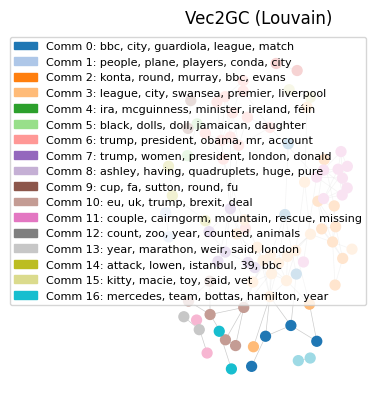

In [9]:
plt.subplot(1, 2, 1)
colors = [partition_louvain[node] for node in G.nodes()]
unique_comms = sorted(set(colors))
nx.draw_networkx_nodes(G, pos, node_size=50, node_color=colors, cmap=plt.cm.tab20)
nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5)
patches = [mpatches.Patch(color=plt.cm.tab20(i/len(unique_comms)),
                          label=f"Comm {i}: {community_keywords_louvain[i]}")
           for i in unique_comms]
plt.legend(handles=patches, loc="best", fontsize=8)
plt.title("Vec2GC (Louvain)", fontsize=12)
plt.axis("off")


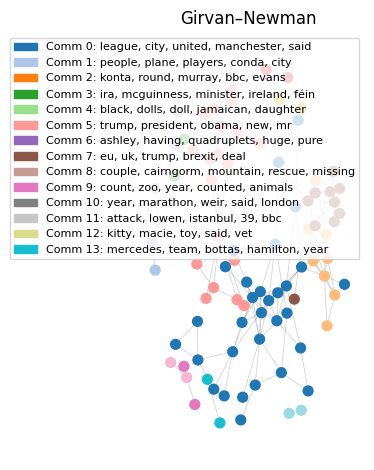

In [10]:
plt.subplot(1, 2, 2)
colors = [partition_gn[node] for node in G.nodes()]
unique_comms = sorted(set(colors))
nx.draw_networkx_nodes(G, pos, node_size=50, node_color=colors, cmap=plt.cm.tab20)
nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5)
patches = [mpatches.Patch(color=plt.cm.tab20(i/len(unique_comms)),
                          label=f"Comm {i}: {community_keywords_gn[i]}")
           for i in unique_comms]
plt.legend(handles=patches, loc="best", fontsize=8)
plt.title("Girvan–Newman", fontsize=12)
plt.axis("off")

plt.tight_layout()
plt.show()

In [1]:
print("hello")

hello


In [1]:
print("prithwiraj")

prithwiraj
